### Part 1

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
from tqdm import *
import os
import matplotlib.pyplot as plt

In [2]:
# Visualize the training process
def plot_loss_accuracy(loss_values, accuracy_values):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(loss_values, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')

    plt.subplot(1, 2, 2)
    plt.plot(accuracy_values, label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')

    plt.tight_layout()
    plt.show()

In [3]:
# Define the CNN model
class CarTemplateClassifier(nn.Module):
    def __init__(self):
        super(CarTemplateClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)  # 2 classes: car and non-car

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
# Load your dataset
data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
# root='path/to/train_data'
train_dataset = ImageFolder(root='train_data', transform=data_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [5]:
# Initialize the model
model = CarTemplateClassifier()

In [6]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# Lists to store training history
loss_values = []
accuracy_values = []

In [8]:
# Training loop
num_epochs = 10

for epoch in tqdm(range(num_epochs)):
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Compute accuracy
        _, predicted_class = torch.max(outputs, 1)
        correct_predictions += (predicted_class == labels).sum().item()
        total_samples += labels.size(0)
        total_loss += loss.item()
    
    # Calculate accuracy and average loss for this epoch
    accuracy = correct_predictions / total_samples
    average_loss = total_loss / len(train_loader)

    # Store values for plotting
    loss_values.append(average_loss)
    accuracy_values.append(accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}]: Loss = {average_loss:.4f}, Accuracy = {accuracy:.4f}")

 19%|███████████████▋                                                                 | 64/331 [05:24<22:30,  5.06s/it]


 39%|███████████████████████████████▍                                                | 130/331 [10:34<15:38,  4.67s/it]


 59%|███████████████████████████████████████████████▎                                | 196/331 [15:17<09:35,  4.27s/it]


 79%|███████████████████████████████████████████████████████████████▎                | 262/331 [19:55<04:48,  4.19s/it]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 328/331 [23:39<00:09,  3.20s/it]


 10%|███████▉                                                                       | 1/10 [23:46<3:33:56, 1426.29s/it]

Epoch [1/10]: Loss = 0.0830, Accuracy = 0.9721



 20%|███████████████▉                                                                 | 65/331 [03:28<15:22,  3.47s/it]


 10%|███████▉                                                                       | 1/10 [27:19<4:05:55, 1639.51s/it]


KeyboardInterrupt: 

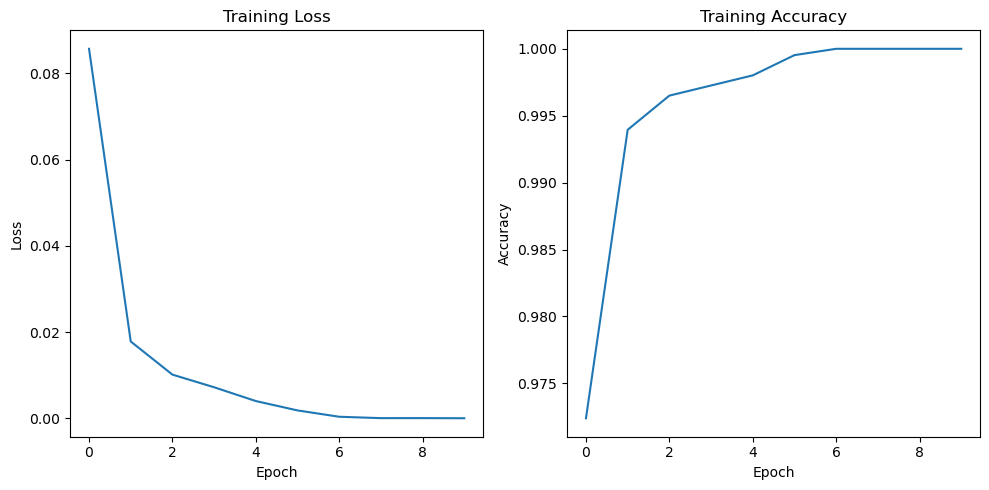

In [9]:
plot_loss_accuracy(loss_values, accuracy_values)

In [7]:
# Save the trained model
torch.save(model.state_dict(), 'car_template_classifier.pth')

### Part 2

In [4]:
# Initialize the model
model = CarTemplateClassifier()

# Load the trained weights
model.load_state_dict(torch.load('car_template_classifier.pth'))
model.eval()  # Set the model to evaluation mode (important for inference)

CarTemplateClassifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [6]:
correct = 0

In [7]:
transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])

In [16]:
cartest_path = "test_car"
cartest_images = os.listdir(cartest_path)
for image in tqdm(cartest_images):
    img_path = cartest_path + '/' + image
    image = Image.open(img_path)
    input_tensor = transform(image).unsqueeze(0)
    
    with torch.no_grad():
        output = model(input_tensor)
    
    _, predicted_class = torch.max(output, 1)
    predicted_probabilities = torch.softmax(output, dim=1)      # innovation
    car_probability = predicted_probabilities[:, 1].item()
    
    threshold = 0.6
    if car_probability > threshold:
        correct = correct + 1

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:15<00:00, 19.88it/s]


In [17]:
noncartest_path = "test_noncar"
noncartest_images = os.listdir(noncartest_path)
for image in tqdm(noncartest_images):
    img_path = noncartest_path + '/' + image
    image = Image.open(img_path)
    input_tensor = transform(image).unsqueeze(0)
    
    with torch.no_grad():
        output = model(input_tensor)
    
    _, predicted_class = torch.max(output, 1)
    predicted_probabilities = torch.softmax(output, dim=1)      # innovation
    car_probability = predicted_probabilities[:, 1].item()
    
    threshold = 0.4
    if car_probability < threshold:
        correct = correct + 1

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:38<00:00,  7.80it/s]


In [19]:
print(correct)
print(correct/600)

476
0.7933333333333333


In [10]:
# Load the test image
image_path = 'OIP-C.jpg'
image = Image.open(image_path)

# Apply the same transformations as during training
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

In [12]:
# Pass the preprocessed image through the model
with torch.no_grad():
    output = model(input_tensor)

# Get the predicted class (0 or 1)
"""
_, predicted_class = torch.max(output, 1)
prediction = predicted_class.item()
"""

# Assuming 'output' contains softmax probabilities (shape: [batch_size, num_classes])
_, predicted_class = torch.max(output, 1)
predicted_probabilities = torch.softmax(output, dim=1)      # innovation
car_probability = predicted_probabilities[:, 1].item()

# Set a threshold (e.g., 0.5)
threshold = 0.5

# Make the final prediction
if car_probability > threshold:
    print("Car template detected!")
else:
    print("No car template detected.")

"""
if prediction == 0:
    print("No car template detected.")
else:
    print("Car template detected!")
"""

# You can also use the probability scores if needed:
# probabilities = torch.softmax(output, dim=1)
# car_probability = probabilities[0, 1].item()

Car template detected!


'\nif prediction == 0:\n    print("No car template detected.")\nelse:\n    print("Car template detected!")\n'